In [11]:
import os
import requests
import pandas as pd
import glob

# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# from tqdm.auto import tqdm
# from tqdm._tqdm_notebook import tqdm_notebook

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

get_ipython().run_line_magic('matplotlib', 'inline')


import mpl_toolkits.basemap
import numpy

import scipy.stats
import seaborn
import sklearn.model_selection
import sklearn.neighbors

seaborn.set()

In [12]:
def get_usgs(start, end, location, min_magnitude=2.5):
    """
    Download Earthquake data from USGS in CSV Format.
    Based on code by kristjan:
    https://earthscience.stackexchange.com/questions/14372/catalog-of-all-significant-earthquakes-since-1900/14373#14373

    Args:
        start: Starting year
        end: Ending year (Leave same as starting year if only one year data is required.)
        location: File location where downloaded files are saved
        min_magnitude: Specified minimum magnitude of seismic data to be downloaded.
                        Example values: 0/1.0/2.5/4.5
                        Default: 2.5
        
    Returns:
        None.
        Saves downloaded data to file.

    Raises:
        None.
    """
    month_days = ['31','28','31','30','31','30','31','31','30','31','30','31']
    for x in range(start,end+1):
        for y in range(1,13):
            url='https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime='+str(x)+'-'+str(y)+'-1%2000:00:00&endtime='+str(x)+'-'+ str(y) +'-'+month_days[y-1]+'%2023:59:59&minmagnitude='+str(min_magnitude)+'&orderby=time-asc'
            print(url)
            response = requests.get(url)
            with open(os.path.join(location, "Earthquake_"+str(x)+"_"+str(y)+".csv"), 'wb') as f:
                f.write(response.content)

In [13]:
get_usgs(2018,2018,os.getcwd(),1)

https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-1-1%2000:00:00&endtime=2018-1-31%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-2-1%2000:00:00&endtime=2018-2-28%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-3-1%2000:00:00&endtime=2018-3-31%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-4-1%2000:00:00&endtime=2018-4-30%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-5-1%2000:00:00&endtime=2018-5-31%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-6-1%2000:00:00&endtime=2018-6-30%2023:59:59&minmagnitude=1&orderby=time-asc
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2018-7-1%2000:00:00&endtime=2018-7-31%2023:59:59&minmagnitude=1&orderby=t

In [14]:
csv_pr = glob.glob('*.{}'.format('csv'))
csv_pr

['Earthquake_2018_2.csv',
 'Earthquake_2018_3.csv',
 'Earthquake_2018_1.csv',
 'Earthquake_2018_4.csv',
 'Earthquake_2018_5.csv',
 'Earthquake_2018_7.csv',
 'Earthquake_2018_6.csv',
 'Earthquake_2018_8.csv',
 'Earthquake_2018_9.csv',
 'Earthquake_2018_12.csv',
 'Earthquake_2018_11.csv',
 'Earthquake_2018_10.csv']

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == 'United States of America']

for files in csv_pr:
    df_temp = pd.read_csv(files)
    df_temp["within_us"] = ""
    withinuslist = []
    try:        
        for lon,lat in zip(df_temp.longitude, df_temp.latitude):
            pt = Point(lon, lat)
            withinus = pt.within(usa['geometry'].values[0])
            withinuslist.append(withinus)
        df_temp['within_us'] = withinuslist
        df_temp = df_temp[df_temp.within_us==True]
        df_temp = df_temp[['time','latitude','longitude', 'depth', 'mag']]
        df_temp.to_csv("all_us\\"+files[:-4]+"_filtered_usa.csv",index=False)
    except:
        continue

In [16]:
df_plot_all = pd.read_csv("all_us\\Earthquake_2018_8_filtered_usa.csv")
df_plot_all.head()

,time,latitude,longitude,depth,mag
0,2018-08-01T00:02:56.480Z,19.416500,-155.270340,0.98,1.85
1,2018-08-01T00:05:57.670Z,19.419001,-155.278671,1.44,1.74
2,2018-08-01T00:14:54.390Z,19.407000,-155.280335,1.05,1.81
3,2018-08-01T00:21:55.510Z,19.413834,-155.261337,0.52,1.74
4,2018-08-01T00:23:35.081Z,58.176300,-155.345400,1.40,1.70


In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geom_all = [Point(xy) for xy in zip(df_plot_all.longitude, df_plot_all.latitude)]

gdf_all = gpd.GeoDataFrame(df_plot_all, geometry=geom_all)

<AxesSubplot: >

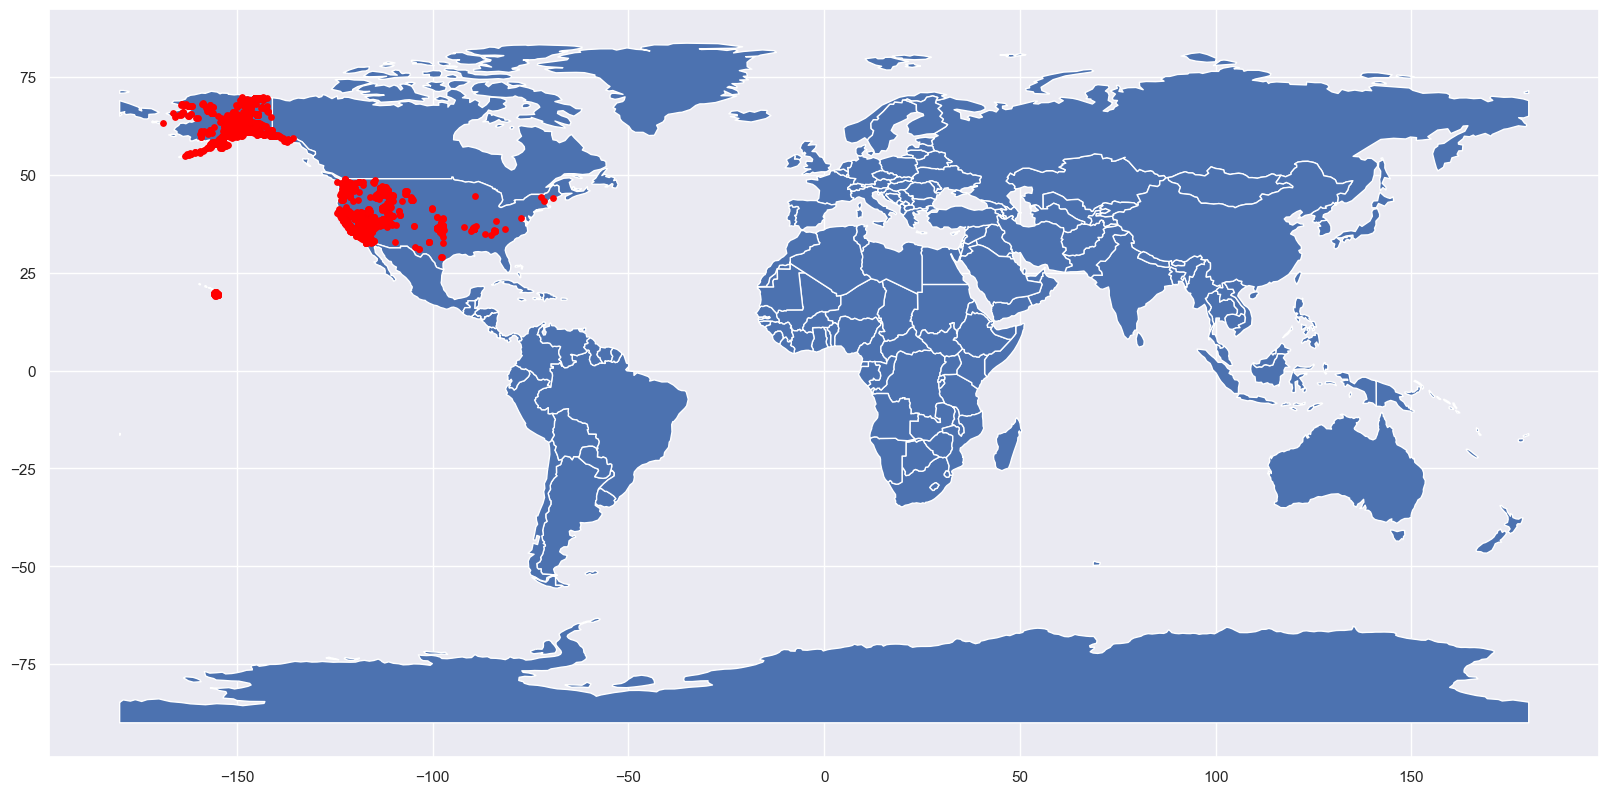

In [18]:
gdf_all.plot(ax=world.plot(figsize=(20,20)), marker='o', color='red',markersize=15)

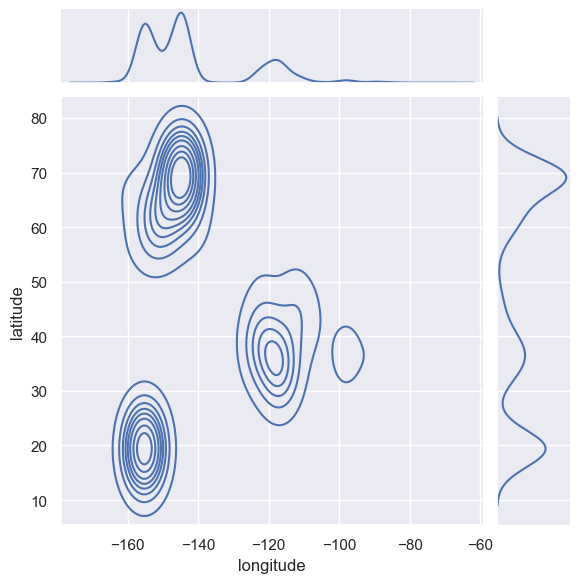

In [19]:
df_all_den = df_plot_all[['latitude', 'longitude']]

seaborn.jointplot(data=df_all_den, x="longitude", y="latitude", kind="kde")

In [20]:
df_large = df_plot_all[df_plot_all['mag'] >= 2.5]
df_large = df_large[['latitude', 'longitude']]


df_large.head()



,latitude,longitude
7,19.407667,-155.272507
24,62.420400,-149.219300
27,19.425333,-155.239166
51,19.407333,-155.257996
67,19.455166,-155.120834


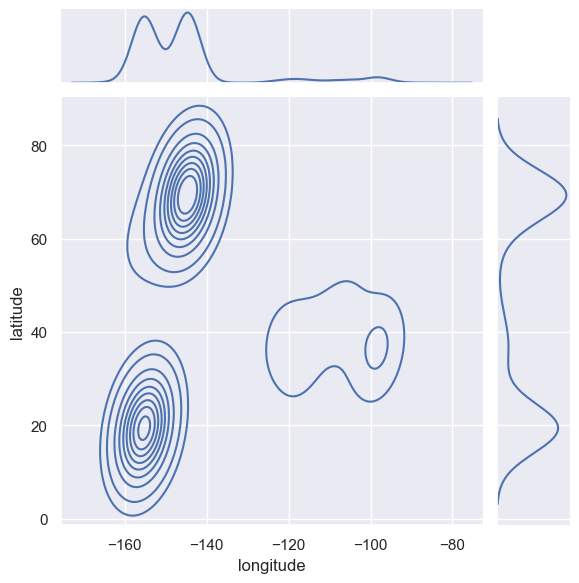

In [21]:

seaborn.jointplot(data=df_large, x="longitude", y="latitude", kind="kde")


In [22]:
# set up the data grid for the contour plot

xgrid25 = numpy.sort(list(df_large['longitude']))
ygrid25 = numpy.sort(list(df_large['latitude']))
x25, y25 = numpy.meshgrid(xgrid25, ygrid25)
print("X Grid Component:\n{}\n".format(x25))
print("Y Grid Component:\n{}\n".format(y25))



X Grid Component:
[[-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]
 [-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]
 [-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]
 ...
 [-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]
 [-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]
 [-163.832     -163.5665    -163.4474    ...  -97.198      -91.9968333
   -84.424    ]]

Y Grid Component:
[[19.1645    19.1645    19.1645    ... 19.1645    19.1645    19.1645   ]
 [19.2010002 19.2010002 19.2010002 ... 19.2010002 19.2010002 19.2010002]
 [19.2033329 19.2033329 19.2033329 ... 19.2033329 19.2033329 19.2033329]
 ...
 [69.6505    69.6505    69.6505    ... 69.6505    69.6505    69.6505   ]
 [69.6551    69.6551    69.6551    ... 69.6551    69.6551    69.6551   ]
 [69.6678    69.6678    69.6678    ... 69.6678    69.6678    69.6

In [23]:
# combine x and y grids into pairs

xy25 = numpy.vstack([y25.ravel(), x25.ravel()]).T

In [24]:
# run kernel density estimation

kde25 = sklearn.neighbors.KernelDensity(
    bandwidth=0.05, 
    metric='minkowski',
    kernel='gaussian', 
    algorithm='ball_tree'
)
kde25.fit(df_large.values)



KernelDensity(algorithm='ball_tree', bandwidth=0.05, metric='minkowski')

In [25]:
# fit the trained model on the xy grid

log_density = kde25.score_samples(xy25)
density = numpy.exp(log_density)
density = density.reshape(x25.shape)
print("Shape of Density Values:\n{}\n".format(density.shape))

Shape of Density Values:
(1717, 1717)



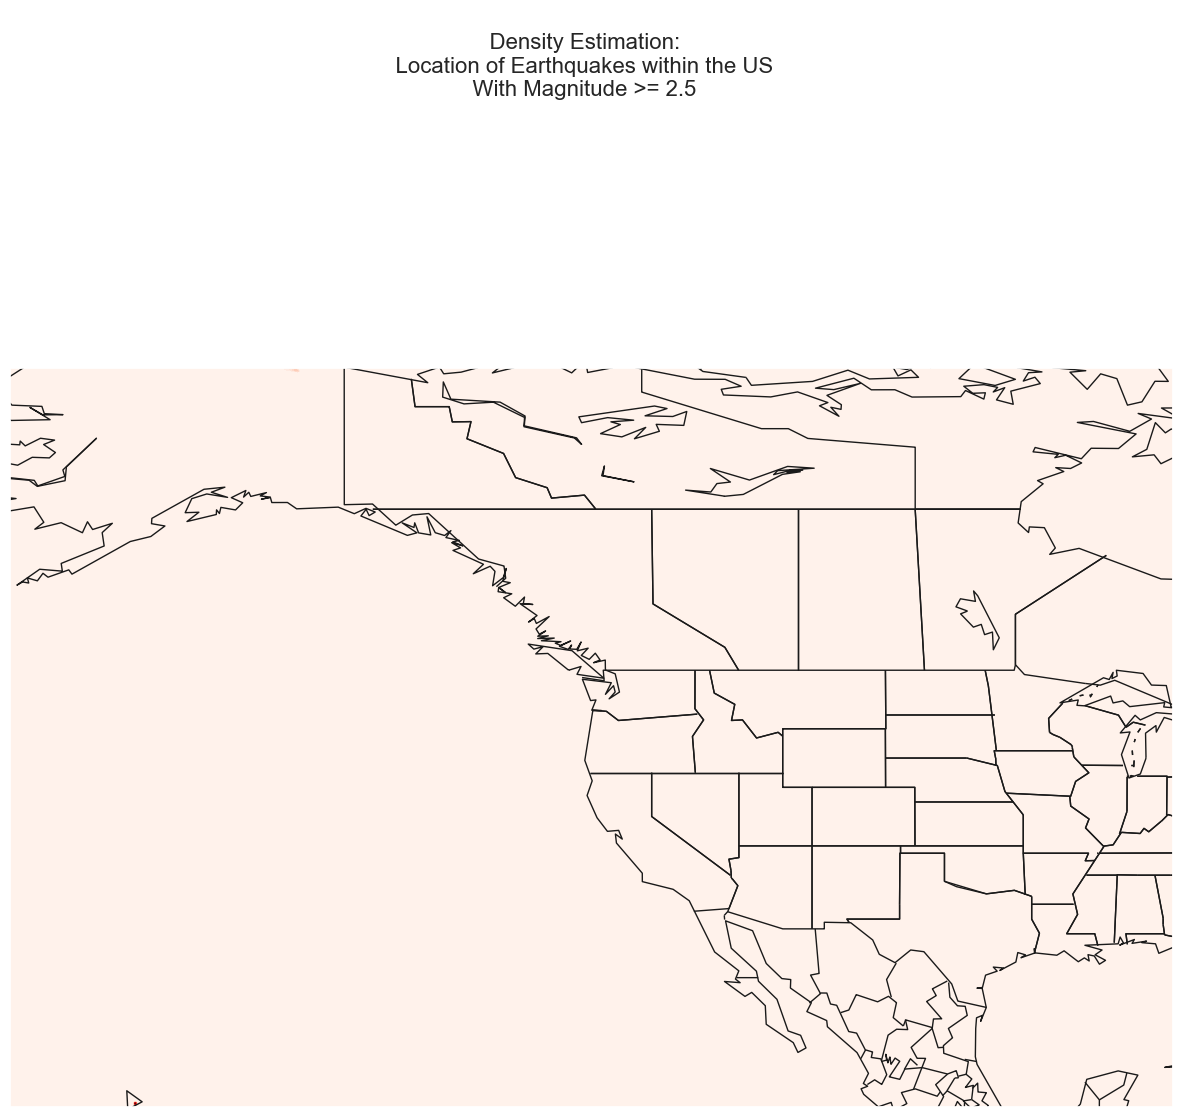

In [26]:


# visualize the results

fig15 = plt.figure(figsize=(15, 15))
fig15.suptitle(
    """
    Density Estimation:
    Location of Earthquakes within the US
    With Magnitude >= 2.5
    """, 
    fontsize=16
)

the_map = mpl_toolkits.basemap.Basemap(
    projection='cyl',
    llcrnrlat=y25.min(), urcrnrlat=y25.max(),
    llcrnrlon=x25.min(),urcrnrlon=x25.max(),
    resolution='c'
)

the_map.drawcoastlines(linewidth=1)
the_map.drawcountries(linewidth=1)
the_map.drawstates(linewidth=1)

levels = numpy.linspace(0, density.max(), 25)
plt.contourf(x25, y25, density, levels=levels, cmap=plt.cm.Reds)

plt.show()



In [27]:
# run kernel density estimation

kde25 = sklearn.neighbors.KernelDensity(
    bandwidth=5, 
    metric='minkowski',
    kernel='gaussian', 
    algorithm='ball_tree'
)
kde25.fit(df_large.values)

# fit the trained model on the xy grid

log_density = kde25.score_samples(xy25)
density = numpy.exp(log_density)
density = density.reshape(x25.shape)
print("Shape of Density Values:\n{}\n".format(density.shape))

Shape of Density Values:
(1717, 1717)



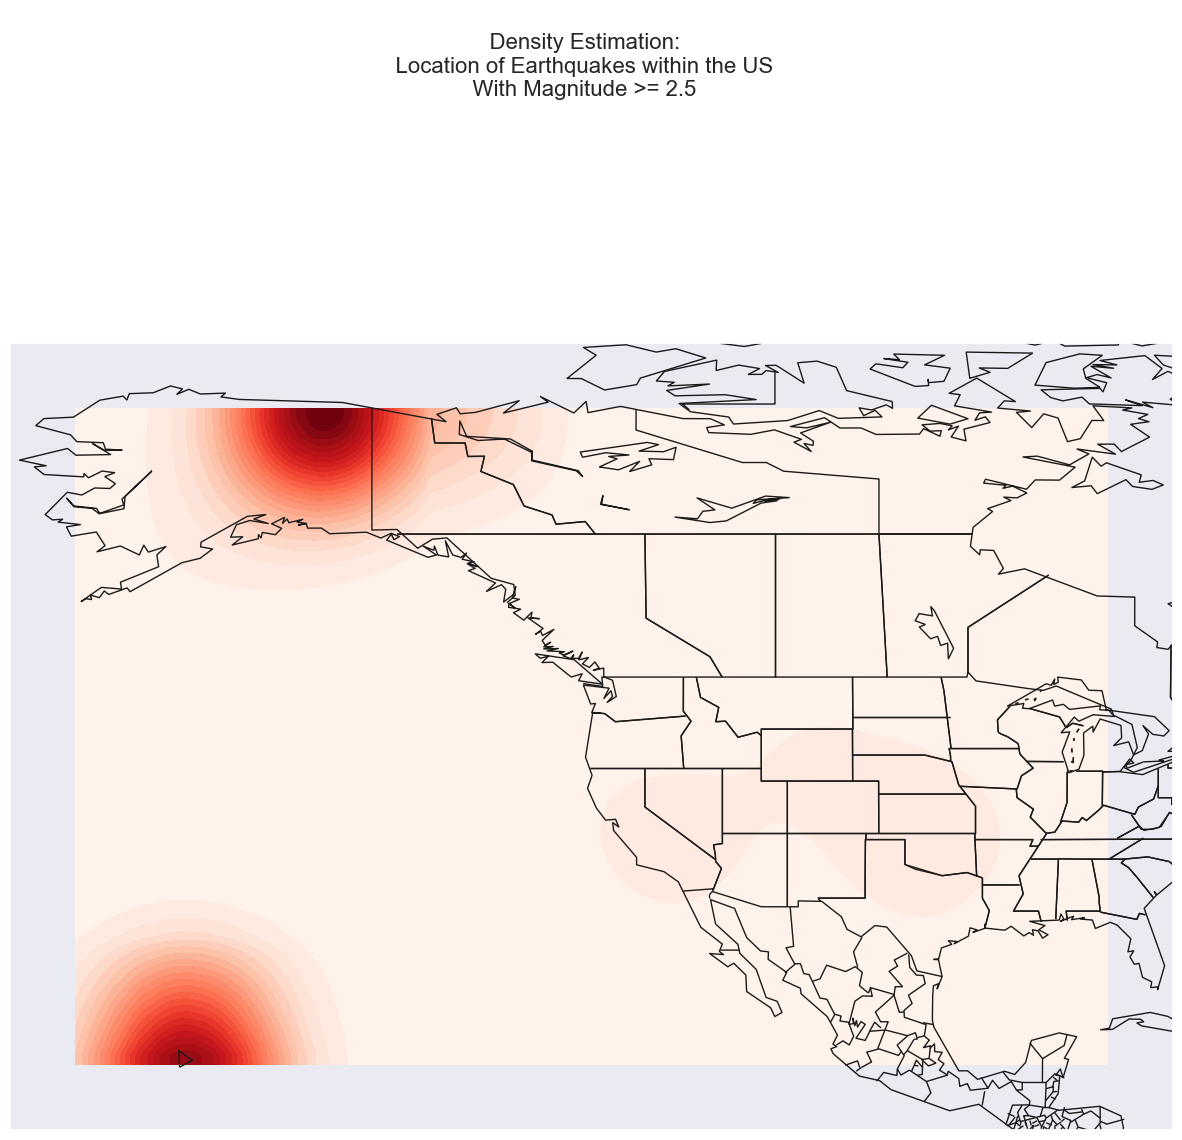

In [28]:
# visualize the results

fig15 = plt.figure(figsize=(15, 15))
fig15.suptitle(
    """
    Density Estimation:
    Location of Earthquakes within the US
    With Magnitude >= 2.5
    """, 
    fontsize=16
)

the_map = mpl_toolkits.basemap.Basemap(
    projection='cyl',
    llcrnrlat=y25.min()-5, urcrnrlat=y25.max()+5,
    llcrnrlon=x25.min()-5,urcrnrlon=x25.max()+5,
    resolution='c'
)

the_map.drawcoastlines(linewidth=1)
the_map.drawcountries(linewidth=1)
the_map.drawstates(linewidth=1)

levels = numpy.linspace(0, density.max(), 25)
plt.contourf(x25, y25, density, levels=levels, cmap=plt.cm.Reds)

plt.show()